In [1]:
from mxnet.gluon import nn,loss
from mxnet import init
import d2l
from mxnet import autograd, gluon, np, npx,nd
import random
import matplotlib.pyplot as plt
import pandas as pd
import os
import mxnet as mx
%matplotlib inline

In [2]:
data_ctx=mx.cpu
model_ctx=mx.cpu

In [3]:
def load_data(path='./data'):
    data=os.path.join(path,'Lemonade.csv')
    return pd.read_csv(data)

data=load_data()

In [4]:
data.head(7)

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,01/01/2017,Sunday,27.0,2.00,15,0.3,10
1,02/01/2017,Monday,28.9,1.33,15,0.3,13
2,03/01/2017,Tuesday,34.5,1.33,27,0.3,15
3,04/01/2017,Wednesday,44.1,1.05,28,0.3,17
4,05/01/2017,Thursday,42.4,1.00,33,0.3,18
5,06/01/2017,Friday,25.3,1.54,23,0.3,11
6,07/01/2017,Saturday,32.9,1.54,19,0.3,13


The above table shows first 7 examples of the dataset (both the features and target variable)


The code below shows first few examples of the features

In [5]:
data.iloc[:,:-1].head()

,Date,Day,Temperature,Rainfall,Flyers,Price
0,01/01/2017,Sunday,27.0,2.00,15,0.3
1,02/01/2017,Monday,28.9,1.33,15,0.3
2,03/01/2017,Tuesday,34.5,1.33,27,0.3
3,04/01/2017,Wednesday,44.1,1.05,28,0.3
4,05/01/2017,Thursday,42.4,1.00,33,0.3


showing first few examples of the target variable sales

In [6]:
data.iloc[:,[-1]].head()

,Sales
0,10
1,13
2,15
3,17
4,18


In [7]:

print( 'the dataset has '+str(data.iloc[:,:-1].shape[0])+" examples with " +str(data.iloc[:,:-1].shape[1])+ " features")

the dataset has 365 examples with 6 features


$\textbf{we are interested in determining whether sales increases with rainy or high temperature }$ days so we are dropping the date and day feature because our focus is not to determine which day increase sales but to know when sales increase base on sunny on rainy day

In [8]:
data.drop(['Date','Day'],axis=1,inplace=True)

In [9]:
data.head(3)

,Temperature,Rainfall,Flyers,Price,Sales
0,27.0,2.00,15,0.3,10
1,28.9,1.33,15,0.3,13
2,34.5,1.33,27,0.3,15


In [10]:

print( 'After dropping the date and day features the dataset now has '+str(data.iloc[:,:-1].shape[1])+
      ' features with '+str(data.iloc[:,:-1].shape[0])+" examples")

After dropping the date and day features the dataset now has 4 features with 365 examples


checking for correlation between the inputs and the target variable

In [11]:
import seaborn as sns

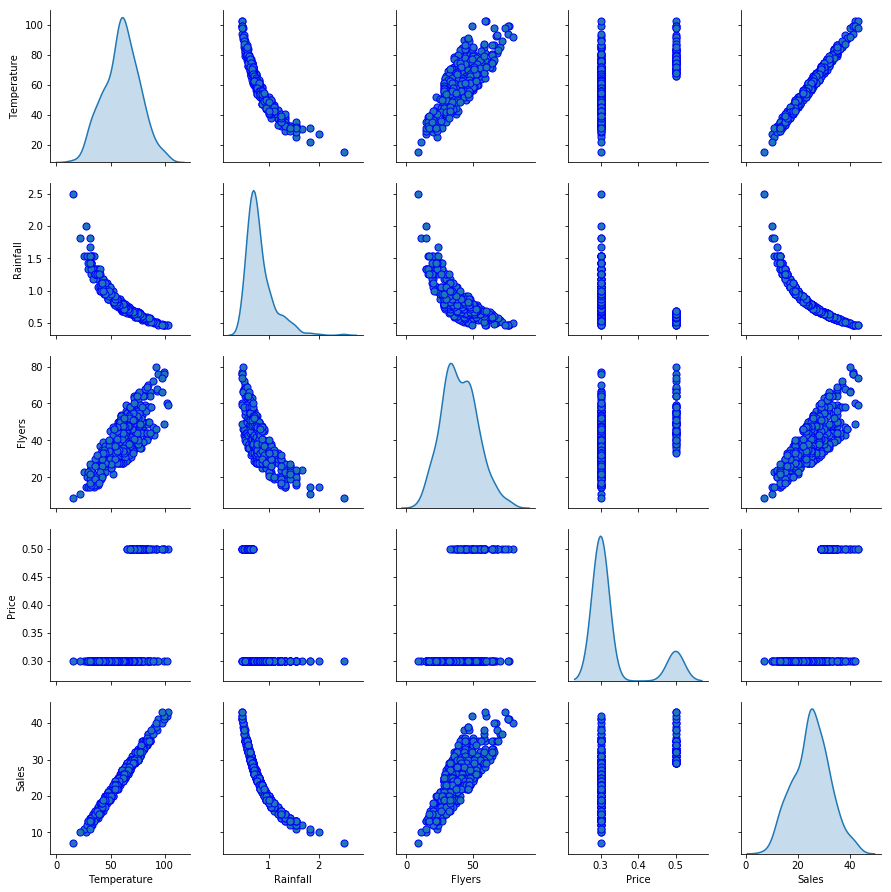

In [12]:
sns.pairplot(data,diag_kind='kde',plot_kws=dict(s=50, edgecolor="b", linewidth=1),diag_kws=dict(shade=True))

from the above diagram we see that

$\bullet$ there is $\textbf{positive correlation between sales and temperature}$  that is sales increase with high temperature and vice versa so for the company to increase it sales it has to make sure it's able to sell a lot of flyers on sunny day becuase sales decreases during rainny days 

$\bullet$ there is a $\textbf{negative correlation between sales and rainfall} $ that is sales decreases with high rainfall and vice versa

$\bullet$ there is a $\textbf{negative correlation between Temperature and rainfall} $ that is Temperature decreases with high rainfall and vice versa


$\bullet$ there is $\textbf{positive correlation between sales and Flyers}$  that is sales increase when a lot of flyers are sold and vice versa which means sales increases when a lot of flyers are sold



# Computing pairwise correlation of between columns

In [13]:
round(data.corr(),3)

,Temperature,Rainfall,Flyers,Price,Sales
Temperature,1.000,-0.903,0.798,0.505,0.990
Rainfall,-0.903,1.000,-0.747,-0.384,-0.909
Flyers,0.798,-0.747,1.000,0.405,0.805
Price,0.505,-0.384,0.405,1.000,0.513
Sales,0.990,-0.909,0.805,0.513,1.000


In [14]:
imputs=data.iloc[:,:-1]
imputs.head()

,Temperature,Rainfall,Flyers,Price
0,27.0,2.00,15,0.3
1,28.9,1.33,15,0.3
2,34.5,1.33,27,0.3
3,44.1,1.05,28,0.3
4,42.4,1.00,33,0.3


In [15]:
imputs.shape

(365, 4)

defining a scaling class to scale all features to have values are within the same range of 0 to 1 [0,1]

In [16]:
class Normalization(gluon.HybridBlock):
    def __init__(self):
        super().__init__()
    def hybrid_forward(self,F,x):
        return F.broadcast_div(F.broadcast_sub(x,F.min(x)), F.broadcast_sub(F.min(x),F.max(x)))

In [17]:
scaler= Normalization()
imputs=scaler(nd.array(imputs))

In [18]:
imputs[1:5]


[[-0.27875245 -0.01003899 -0.14327486 -0.        ]
 [-0.33333334 -0.01003899 -0.26023394 -0.        ]
 [-0.4269006  -0.00730994 -0.26998052 -0.        ]
 [-0.4103314  -0.00682261 -0.31871346 -0.        ]]
<NDArray 4x4 @cpu(0)>

In [19]:
target=nd.array(data.iloc[:,[-1]])

In [20]:
def load_array(features,labels, batch_size):
    dataset=gluon.data.ArrayDataset(*(features,labels))
    dataloader=gluon.data.DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
    return dataloader

In [21]:
train_loader=load_array(features=imputs,labels=target,batch_size=100)

# Defining the Model

In Gluon, the fully-connected layer is defined in the Dense class. Since we
only want to generate a single scalar output, we set that number to 1


In [22]:
net=nn.Sequential()
net.add(nn.Dense(1))

In [23]:
net.collect_params()

sequential0_ (
  Parameter dense0_weight (shape=(1, 0), dtype=float32)
  Parameter dense0_bias (shape=(1,), dtype=float32)
)

# Initializing Model Parameters¶
initializing the parameter (weights and bias) randomly from a normal distribution with mean 0 and standard deviation 0:01. Both the weight vector and bias will have attached gradients


In [24]:

net.initialize(init.Normal(sigma=0.01))        

# loss function
we will be calculating the mean squared error between true value and predited value
$$ L = \frac{1}{n} \sum_i \vert {label}_{i} - {pred}_i \vert^2.$$

In [25]:
loss=loss.L2Loss()

In [26]:
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.1})

In [27]:
batch_size=100
num_epochs=500
for epoch in range(num_epochs+1):
    for X,y in train_loader:
        with autograd.record():
            y_pred=net(X)
            l2=loss(y_pred,y)
        l2.backward()
        trainer.step(batch_size)
    loss_f=loss(net(imputs),target)
    if epoch %50==0:
        print('epoch %d, loss: %f' % (epoch, loss_f.mean().asnumpy()))
       

epoch 0, loss: 112.179588
epoch 50, loss: 5.062810
epoch 100, loss: 2.771032
epoch 150, loss: 1.783961
epoch 200, loss: 1.332573
epoch 250, loss: 1.104820
epoch 300, loss: 0.973497
epoch 350, loss: 0.886571
epoch 400, loss: 0.822138
epoch 450, loss: 0.770722
epoch 500, loss: 0.728030
